# MultiLayer Neural Netork And Convolutional Neural Network
Esta es la arquitectura de una red multicapa 
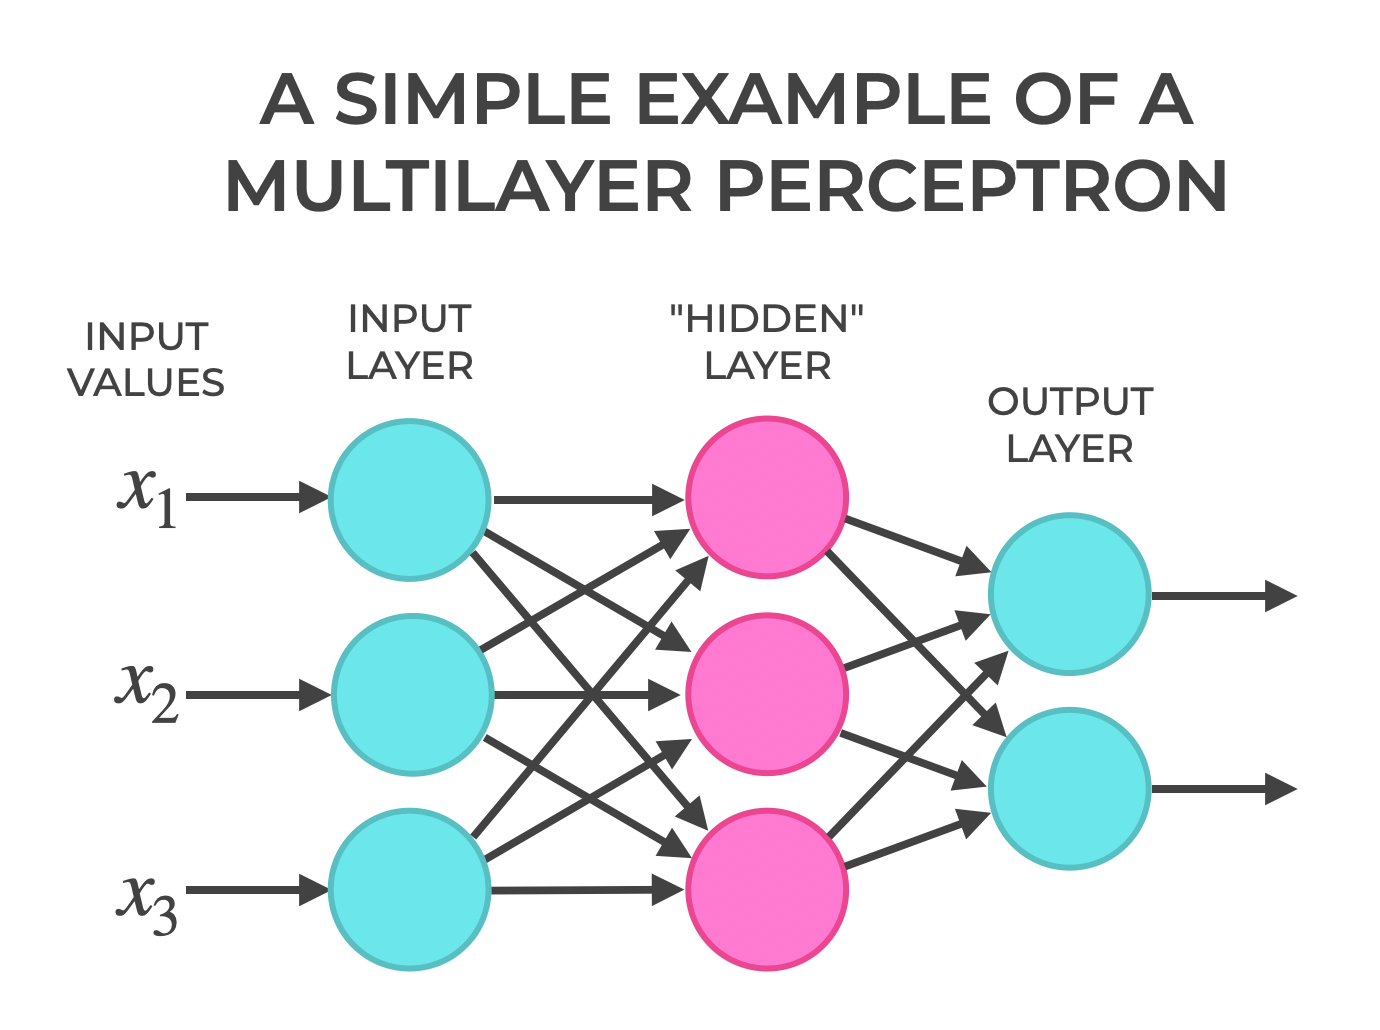
> La entrada es el primer perceptron que teníamos en el ejercicio del perceptron, sin embargo, al final de la capa de entrada, sigue una capa oculta, a estas partes soluciones lineales-no lineales que hacen el calculo en cada capa, se le llama Fully connected. La Segunda capa entonces es otra capa de abstracción, gracias a ella, la red puede encontrar ciertos patrones especificos. La red aprende a deformar el espacio. 

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        """
        Args:
            input_dim(int): el tamaño de los veectores de entradad
            hidden_dim(int): el tamaño de salida de la primera Capa completa conectada FC1
            output_dim(int): tamaño de salida de la FC2
            """
        super(MultilayerPerceptron,self).__init__()
        self.fc1= nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,output_dim)
    def forward(self, x_in,apply_softmax=False):
        """ El paso hacia adelante de MLP
        Args: 
            x_in (torch.Tensor) : Un tensor de dato de entrada de x_in.shape debe ser (batch, input_dim)
            apply_softmax (bool): una bandera para la activacon del softmax debe ser falsa si es usada con las perdidads dde entropia cruzada
        Returns:
            el tensor resultante con un tamaño de (batch,output_dim)
        """
        intermediate=F.relu(self.fc1(x_in))
        output=self.fc2(intermediate)
        if apply_softmax:
            output=F.softmax(output,dim=1)
        return output

In [9]:
batch_size=2 #Numero de muestras en la entradad
input_dim=3
hidden_dim=100
output_dim=4
#Inicializar modelo
mlp=MultilayerPerceptron(input_dim,hidden_dim,output_dim)
print(mlp)

MultilayerPerceptron(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)


In [10]:
def describe(x):
    print(f"Type {x.type}")
    print(f"Shape/size {x.shape}")
    print(f"Values {x}")
x_input=torch.rand(batch_size,input_dim)
describe(x_input)

Type <built-in method type of Tensor object at 0x000001F406B77890>
Shape/size torch.Size([2, 3])
Values tensor([[0.0017, 0.4376, 0.9758],
        [0.0756, 0.2284, 0.4329]])


In [12]:
y_out=mlp(x_input,apply_softmax=True)
describe(y_out)

Type <built-in method type of Tensor object at 0x000001F405B62A80>
Shape/size torch.Size([2, 4])
Values tensor([[0.1951, 0.2364, 0.2285, 0.3400],
        [0.2123, 0.2226, 0.2320, 0.3331]], grad_fn=<SoftmaxBackward0>)


# Preprocesamiento de texxto
> Aqui vamos a hcaer la tarea de calisficacion d idiomas, esto es muy importante, porque voy a necesitar crear una maquina que sepa identificar idiomas.
    Adicionalmente le crearé más conjuntos de datos para que identifique idiomas de forma más inteligente

In [13]:
import collections
import numpy as np
import pandas as pd
import re
from argparse import Namespace

In [16]:
args = Namespace(
    raw_dataset="data/surnames/surnames.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/surnames/surnames_with_splits.csv",
    seed=1337
)

In [17]:
surnames=pd.read_csv(args.raw_dataset,header=0)

In [18]:
surnames.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [19]:
set(surnames.nationality)

{'Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese'}

In [23]:
by_nationality = collections.defaultdict(list)
for _, row in surnames.iterrows():
    by_nationality[row.nationality].append(row.to_dict())


In [24]:
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_nationality.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [25]:
final_surnames = pd.DataFrame(final_list)

In [26]:

final_surnames.split.value_counts()

split
train    7680
test     1660
val      1640
Name: count, dtype: int64

In [27]:

final_surnames.head()

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train


# Uso de las clases previamente usadas

# Dataset

In [86]:
from torch.utils.data import Dataset
class SurnameDataset(Dataset):
    # Se hereda la clase Dataset
    def __init__(self,surname_df,vectorizer):
        """
        Args:
            review_df(pandas.DataFrame): El conjunto de datos
            vectorizer(ReviewVectorizer): vectorizer instacinado desde el conjunto de datos
        """
        self.review_df = surname_df
        self._vectorizer = vectorizer
        self.train_df= self.review_df[self.review_df.split=="train"]
        self.train_size=len(self.train_df)

        self.val_df= self.review_df[self.review_df.split=="val"]
        self.val_size=len(self.val_df)

        self.test_df= self.review_df[self.review_df.split=="test"]
        self.test_size=len(self.test_df)

        self._lookup_dic={'train':(self.train_df,self.train_size),
                         'val':(self.val_df,self.val_size),
                         'test':(self.test_df,self.test_size),
                         }
        self.set_split("train")
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
    @classmethod
    def load_dataset_and_make_vectorizer(cls,review_cls):
        """
        carga el dataset y hacer un nuevo vectorizador desde cero
        args:
                review_cvs(str): ubicacion del dataset
        Returns:
            una instancia de ReviewDataset
        """
        surname_df= pd.read_csv(review_cls)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df,SurnameVectorizer.from_dataframe(train_surname_df))
    def get_vectorizer(self):
        """retorna el vectorizador"""
        return self._vectorizer
    def set_split(self,split="train"):
        """
        Selecciona la division en el conjunto de datos usando una columna en el dataframe
        args:
        split(str):  uno de "train","val","test"
        """
        self._target_split=split
        self._target_df,self._target_size=self._lookup_dic[split]
    def __len__(self):
        return self._target_size
    def __getitem__(self,index):
        """
        El punto primario de entrada como metodo para PyTorch en lso conjuntos de datos
        Args:
        index(int): Es el inice del dato
        Returns:
            Diccionario de las caracterizitcads de los puntos de datos y labels
        """
        row=self._target_df.iloc[index]
        surname_vector=self._vectorizer.vectorize(row.surname)
        nationality_index=self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        return {'x_data':surname_vector,
               'y_data':nationality_index}
    def get_num_batches(self,batch_size):
        """
        Dado un tamaño de batch , retorna el numero de batches del conjunto de datos
        Args:
            batch_size(int)
        Returns:
            Numero de batches en el conjuntos
        """
        return len(self)//batch_size

# Vocabulary
It is exactly the same thing

In [87]:
class Vocabulary(object):
    """ Clase a procesar texto y extrar el vocabulario para mappear"""
    def __init__(self,token_to_idx=None,add_unk=True,unk_token="<UNK>"):
        """Args:
            token_to_idx (dict): un mapa pre existen de toknes a indices
            add_unk(bool): un bandera que indica si se añade el token UNK de desconocido
            unk_token(str): el token UNK se añade a el vocabulario
            """
        if token_to_idx is None:
            token_to_idx={}
        self._token_to_idx=token_to_idx
        self._idx_to_token={idx: token
                           for token,idx in self._token_to_idx.items()}
        self._add_unk=add_unk
        self._unk_token=unk_token
        self.unk_index=-1
        if add_unk:
            self.unk_index=self.add_token(unk_token)
    def to_serializable(self):
        """ Retorna un diccionario que puede ser serializado """
        return {"token_to_idx":self._token_to_idx,
               "add_unk":self._add_unk,
               "unk_token":self._unk_token}
    @classmethod
    def from_serializable(cls,contents):
        """instancia el bocabulario desde un diccionario serializado"""
        return cls(**contents)
    def add_token(self,token):
        """
        Actualiza los mapeos de diccionarrios basados en los tokens
        Args:
            token (str): el item a añadir en el vocabulario
        Returns:
            index(int) : el entero correspondiente al token
        """
        if token in self._token_to_idx:
            index=self._token_to_idx[token]
        else:
            index=len(self._token_to_idx)
            self._token_to_idx[token]=index
            self._idx_to_token[index]=token
        return index
    def lookup_token(self,token):
        """ Obtiene el indice asociado con el tokenn de UNK token si el token no está presente,
        Args:
            token (str): el token a observar
        returns :
            index (int) el indices correspondiente al token
        Notes:
               `unk_index` necesita ser entero positivo (habiendo sido añadido al vocabulario) para la funcionalidad desconocidad
               """
        if self._add_unk:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self,index):
        """ Obtiene el token asociado al indice
        Args:
            index (int): el indice a observar
        returns :
            token (str) el token correspondiendte al indices
        Raises:
            KeyError: si el indice no está en el vocabulario
        """
        if index not in self._idx_to_token:
            raise KeyError("El indice (%d)no está en el vocabulario" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):#Refleja la longitudad del vocabulario
        return len(self._token_to_idx)

# The vectorizere has its own mods

In [88]:
from collections import Counter
import string
class SurnameVectorizer(object):
    """ La clase vectorizer de las cuales, suss coordenadas son las del vocabulario"""
    def __init__(self,surname_vocab,nationality_vocab):
        self.surname_vocab= surname_vocab
        self.nationality_vocab = nationality_vocab
    def vectorize(self,surname):
        """ 
        Crea un vecctor colapsado para la reseña
        Args:
            review(str) : una reseña
        Returns:
            one_hot (np.ndarray): la codificacion colapsadad 
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab),dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot
    @classmethod
    def from_dataframe(cls,surname_df):
        """
        Instancia el vectorizer desde el conjunto de datos del dataframe

        Args:
            review_df (pandas.Dataframe): el conjunto de datos de reseñas
            cuttof(int): el parametro para el filtro de basado en frecuencia
        Returns
        una instacia del ReviewVectorizer
        """
        surname_vocab=Vocabulary(unk_token="@")
        nationality_vocab=Vocabulary(add_unk=False)
        for index,row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab,nationality_vocab)
    @classmethod 
    def from_serializable(cls,contents):
        """
        Instancia una ReviewCectorizer desde un diccionario serializavle
        Args:
                contents(dicT): el diccionario serializable
        Returns:
            Una instancia de ReviewVectorizer class
        """
        review_vocab=Vocabulary.from_serializable(contents["review_vocab"])
        rating_vocab=Vocabulary.from_serializable(contents["rating_vocab"])
        return cls(review_vocab,rating_vocab)
    def to_serializable(self):
        """Crea un diccionario seralizable para el chace
        Returns:
            contents(ditc): el diccionario serializable
        """
        return {"review_vocab": self.review_vocab.to_serializable(),
               "rating_vocab": self.rating_vocab.to_serializable()}

# The neural network
La red neuronal utilizada, es la misma que de la introducción.
    La primera capaeta compuesta por la entrada,despues la capa oculta y al fina, la capa de predicción
Las seccion de fully connected, todas son lineales, como está en la forumla. La primerea sele pasa una funcin relu y la seguda, si se desea aplicar la prediccion, se le aplica una softmax

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SurnameClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        """
        Args:
            input_dim(int): el tamaño de los veectores de entradad
            hidden_dim(int): el tamaño de salida de la primera Capa completa conectada FC1
            output_dim(int): tamaño de salida de la FC2
            """
        super(SurnameClassifier,self).__init__()
        self.fc1= nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,output_dim)
    def forward(self, x_in,apply_softmax=False):
        """ El paso hacia adelante de MLP
        Args: 
            x_in (torch.Tensor) : Un tensor de dato de entrada de x_in.shape debe ser (batch, input_dim)
            apply_softmax (bool): una bandera para la activacon del softmax debe ser falsa si es usada con las perdidads dde entropia cruzada
        Returns:
            el tensor resultante con un tamaño de (batch,output_dim)
        """
        intermediate=F.relu(self.fc1(x_in))
        output=self.fc2(F.dropout(intermediate,p=0.5))
        if apply_softmax:
            output=F.softmax(output,dim=1)
        return output

# Rutina de entrenamiento
La rutina, es la misma que en la sección de redes neuronales, solamnete con otros argumentos

In [146]:
args=Namespace(
    #Datos y direcciones
    cuda=True,
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_nlp",
    hidden_dim=300,
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    )

## instancias de dataset, optimizador, device, funcion de perdida

In [147]:
#El conjunto de datos instanciado
import torch.optim as optim
dataset=SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer= dataset.get_vectorizer()

classifier=SurnameClassifier(input_dim=len(vectorizer.surname_vocab),
                            hidden_dim=args.hidden_dim,
                             output_dim=len(vectorizer.nationality_vocab))
if not torch.cuda.is_available():
    args.cuda=False
args.device= torch.device("cuda" if args.cuda else "cpu")
classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func=nn.CrossEntropyLoss(dataset.class_weights)
optimizer=optim.Adam(classifier.parameters(),lr=args.learning_rate)

## Funciones de utilidades

In [148]:
def make_train_state(args):
    return { "epoch_index":0,
             "train_loss": [],
             "train_acc":[],
             "val_loss":[],
             "val_acc":[],
             "test_loss":-1,
             "test_acc":-1}
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100
def generate_batches(dataset,batch_size,shuffle=True,
                     drop_last=True,device="cpu"):
    """Una funcion generation la que wrapea ek dataloader de pytorxh. SE asegurarar de que cada tesnor este en un unico dispositivo
    """
    dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Entrenamiento

In [149]:
from torch.utils.data import DataLoader
train_state=make_train_state(args)
for epoch_index in range(args.num_epochs):
    train_state['epoch_index']=epoch_index
    # Itera sobre nuestro dataset
    #Configura: el generador de batch, la perdidad, el accuracy a 0 y el conjunto de entrenamiento a activo
    dataset.set_split("train")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.train()
    for batch_index,batch_dict in enumerate(batch_generator):
        
        # La rutina de entrenamiento se conforma de 5 pasos

        #paso 1, los gradientes en cero
        optimizer.zero_grad()
        #Paso . calcula la salida
        y_pred=classifier(x_in=batch_dict["x_data"].float())
        #paso 3, calcula la perdidad
        loss=loss_func(y_pred,batch_dict["y_data"])
        loss_batch=loss.to("cpu").item()
        running_loss+=(loss_batch-running_loss)/(batch_index+1)
        #paso 4, usa la perdidad para producir el gradiente
        loss.backward()
        #Paso 5, usa el otpimizar para que tomo el paso gradiente
        optimizer.step()

        ##Calcula el accuracy
        acc_batch=compute_accuracy(y_pred,batch_dict["y_data"])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)

    #Iterar sobre el dataset de validacion
    #Configura, el generator de batch, la perdiddad, el accuracy a 0 y modo eval
    dataset.set_split("val")
    batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
    running_loss=0.0
    running_acc=0.0
    classifier.eval()
    #Empieza la evaluacion
    for batch_index,batch_dict in enumerate(batch_generator):
        # Paso 1: calcula la salida
        y_pred=classifier(x_in=batch_dict["x_data"].float())
        # paso 2, calcula la salida
        loss = loss_func(y_pred,batch_dict['y_data'])
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss)/(batch_index+1)
        #paso 3, calcula el accuracy
        acc_batch= compute_accuracy(y_pred,batch_dict['y_data'])
        running_acc+=(acc_batch-running_acc)/(batch_index+1)
    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)

# Evaluacion

In [150]:
dataset.set_split("test")
batch_generator=generate_batches(dataset,batch_size=args.batch_size,device=args.device)
running_loss=0.
running_acc=0.
classifier.eval()
print("comienza la evaluacion")
for batch_index,batch_dict in enumerate(batch_generator):
    print("batch: ",batch_index)
    #Compute the output
    y_pred=classifier(x_in=batch_dict["x_data"].float())
    # calcula la perdidad
    loss = loss_func(y_pred,batch_dict["y_data"])
    loss_batch= loss.item()
    running_loss += (loss_batch-running_loss)/(batch_index+1)
    #Calcula el accuracy 
    acc_batch= compute_accuracy(y_pred,batch_dict["y_data"])
    running_acc+=(acc_batch-running_acc)/(batch_index+1)
train_state["test_loss"]= running_loss
train_state["test_acc"] = running_acc

comienza la evaluacion
batch:  0
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20
batch:  21
batch:  22
batch:  23
batch:  24


In [151]:
print(train_state["test_acc"])

50.3125


In [152]:
def predict_class(name,classifier, vectorizer):
    vectorized_name=vectorizer.vectorize(name)
    vectorized_name=torch.tensor(vectorized_name).view(1,-1) #Se convierte ahora en un tensor
    result = classifier(vectorized_name,apply_softmax=True)
    probability_values,indices= result.max(dim=1)
    index=indices.item()
    predicted_nationality=vectorizer.nationality_vocab.lookup_index(index)
    probability_value=probability_values.item()
    return {"nationality": predicted_nationality,
            "probability": probability_value
            }

In [153]:
def predict_topk_nationality(name,classifier, vectorizer, k=5):
    vectorize_name = vectorizer.vectorize(name)
    vectorize_name = torch.tensor(vectorize_name).view(1,-1)
    prediction_vector=classifier(vectorize_name,apply_softmax=True)

    # retorna el tamaño 1,k
    probability_values,indices= torch.topk(prediction_vector,k=5)
    probability_values=probability_values.detach().numpy()[0]
    indices=indices.detach().numpy()[0]

    results=[]
    for prob_value , index in zip(probability_values,indices):
        nationality=vectorizer.nationality_vocab.lookup_index(index)
        results.append({"nationality": nationality,
                       "probability": prob_value})
    return results

In [154]:
classifier=classifier.to("cpu")

resultado=predict_class("Van der Linde",classifier,vectorizer)
print(resultado)

{'nationality': 'French', 'probability': 0.47709646821022034}


In [155]:

resultado=predict_topk_nationality("Van Der Linde",classifier,vectorizer)
print(resultado)

[{'nationality': 'French', 'probability': np.float32(0.68423253)}, {'nationality': 'Dutch', 'probability': np.float32(0.14060888)}, {'nationality': 'Italian', 'probability': np.float32(0.084917635)}, {'nationality': 'German', 'probability': np.float32(0.02757198)}, {'nationality': 'English', 'probability': np.float32(0.027191717)}]
